In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install arch

In [4]:

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse, r2_score

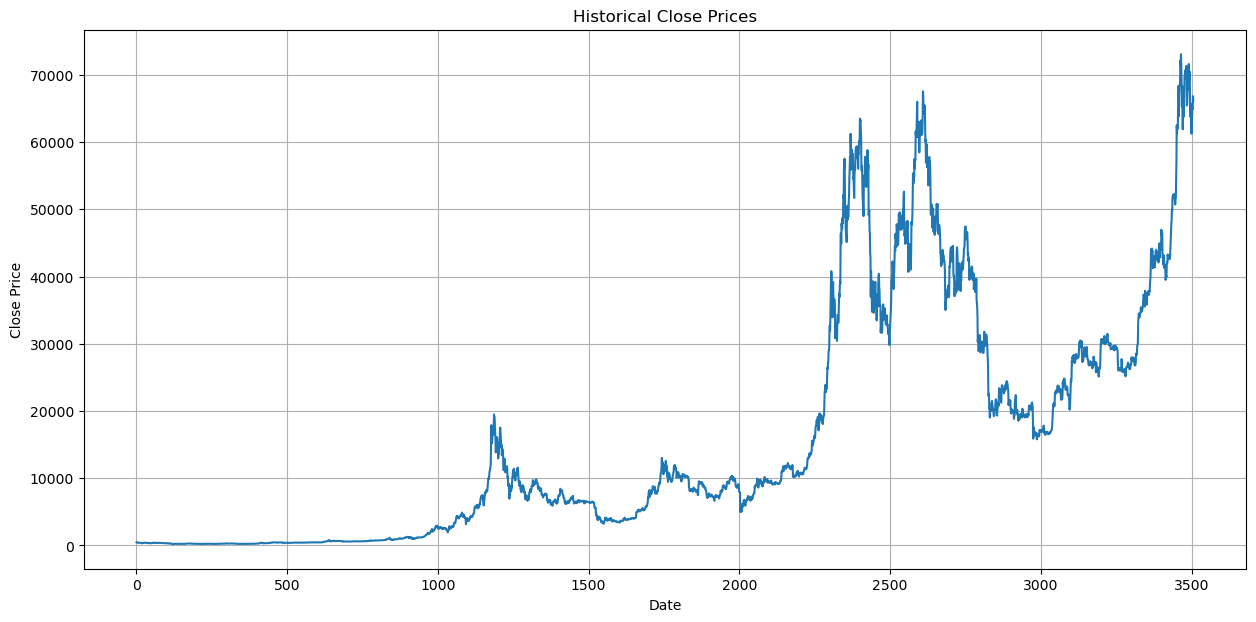

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


start = datetime(2019, 1, 1)
end = datetime.today()

tckr = 'BTC-USD'
ticker_historical = pd.read_csv('~/Desktop/untitled folder/abc.csv')


plt.figure(figsize=(15,7))
plt.plot(ticker_historical['Close'])
plt.title('Historical Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


In [6]:
returns = 100 * ticker_historical.Close.pct_change().dropna()

In [7]:
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
log_returns = np.log(ticker_historical.Close/ticker_historical.Close.shift(1)).dropna()

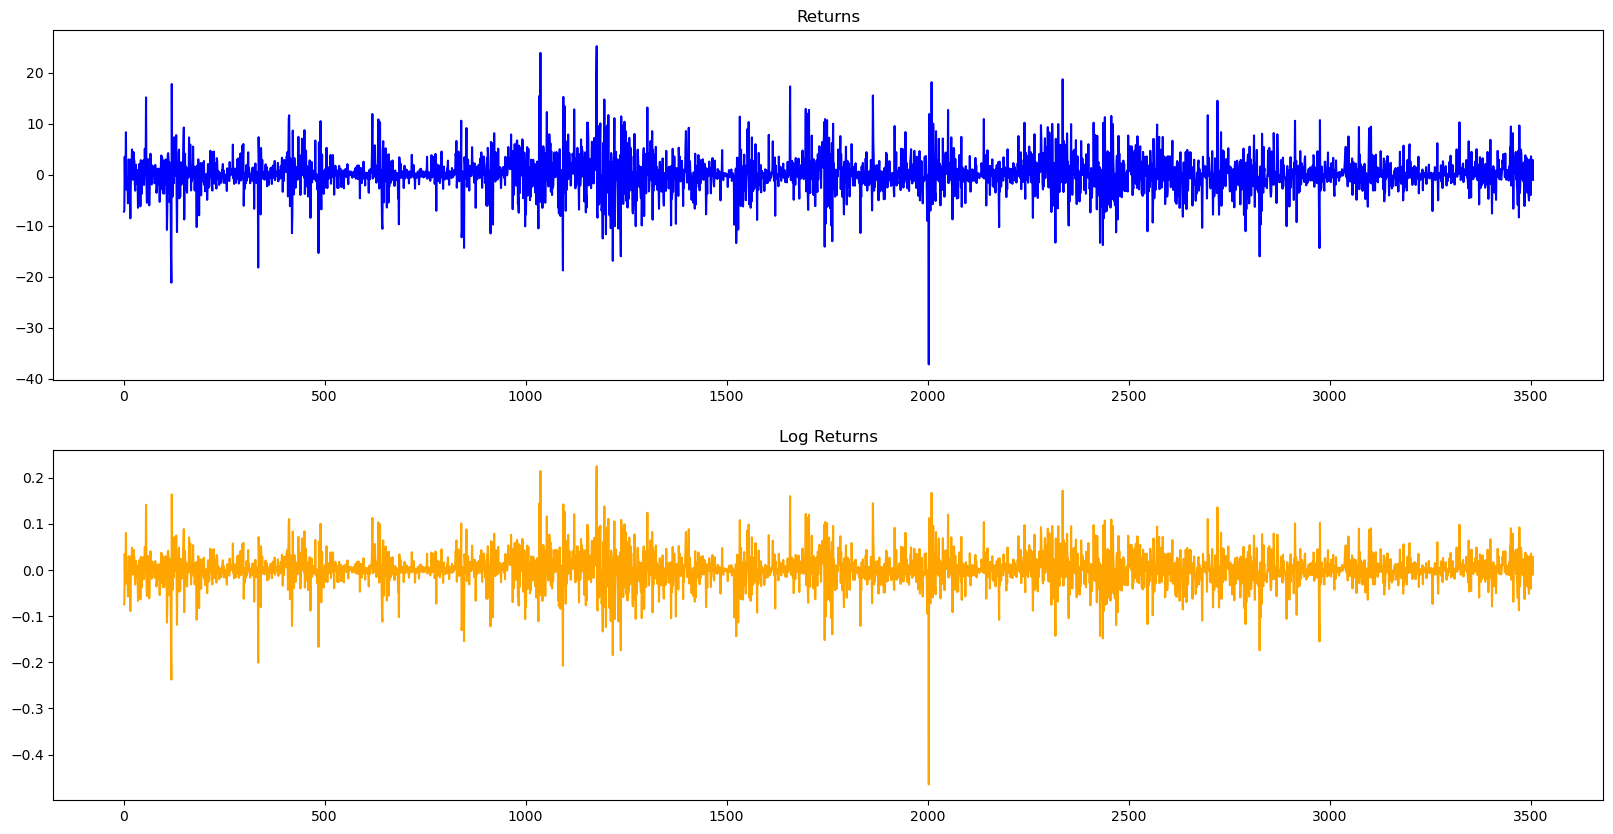

In [8]:
# VISUALIZE RETURNS VS. LOG RETURNS
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

ax1.plot(returns, color='blue')
ax1.set_title('Returns')

ax2.plot(log_returns, color='orange')
ax2.set_title('Log Returns')

fig.show();

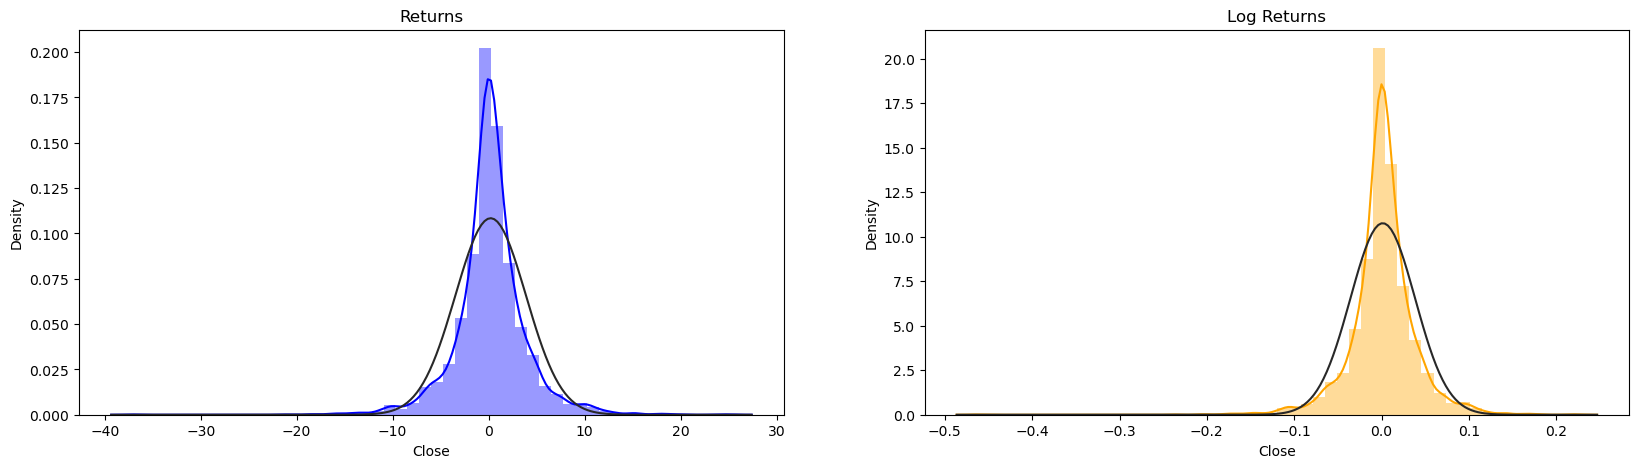

In [9]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.distplot(returns, norm_hist=True, fit=stats.norm, color='blue',
             bins=50, ax=ax1)
ax1.set_title('Returns')

sns.distplot(log_returns, norm_hist=True, fit=stats.norm, color='orange',
             bins=50, ax=ax2)
ax2.set_title('Log Returns')

fig.show();

In [10]:
returns.describe()

count    3506.000000
mean        0.210328
std         3.681248
min       -37.169539
25%        -1.241155
50%         0.142533
75%         1.728504
max        25.247169
Name: Close, dtype: float64

In [11]:
log_returns.describe()

count    3506.000000
mean        0.001419
std         0.037092
min        -0.464730
25%        -0.012489
50%         0.001424
75%         0.017137
max         0.225119
Name: Close, dtype: float64

In [12]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
def realized_volatility(series_log_return):
    """
    Get realized volatility which is calculated as the square root
    of sum of squares of log returns
    """
    return np.sqrt(np.sum(series_log_return**2))

In [13]:
log_returns.apply(realized_volatility)

1       0.074643
2       0.072402
3       0.035111
4       0.024968
5       0.008317
          ...   
3502    0.005195
3503    0.017866
3504    0.001044
3505    0.029009
3506    0.009884
Name: Close, Length: 3506, dtype: float64

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
adfuller_results = adfuller(log_returns)

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -17.990347259957403
p-value: 2.755696044243832e-30
Critical Values:
1%: -3.4322
5%: -2.8624
10%: -2.5672


In [16]:
ticker_historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3507 entries, 0 to 3506
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          3507 non-null   object 
 1   Open          3507 non-null   float64
 2   High          3507 non-null   float64
 3   Low           3507 non-null   float64
 4   Close         3507 non-null   float64
 5   Volume        3507 non-null   int64  
 6   Dividends     3507 non-null   float64
 7   Stock Splits  3507 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 219.3+ KB


In [17]:
split_time_1 = 2000
split_time_2 = 2500

train_idx = log_returns.index[:split_time_1]
val_idx = log_returns.index[split_time_1:split_time_2]
test_idx = log_returns.index[split_time_2:]

In [18]:
ts_train = log_returns[train_idx]
ts_val = log_returns[val_idx]
ts_test = log_returns[test_idx]

In [19]:
# GET VOLATILITY SERIES vols
vols = log_returns.apply(realized_volatility)

# SPLIT vols INTO 3 PARTS
vol_train = vols[train_idx]
vol_val = vols[val_idx]
vol_test = vols[test_idx]

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

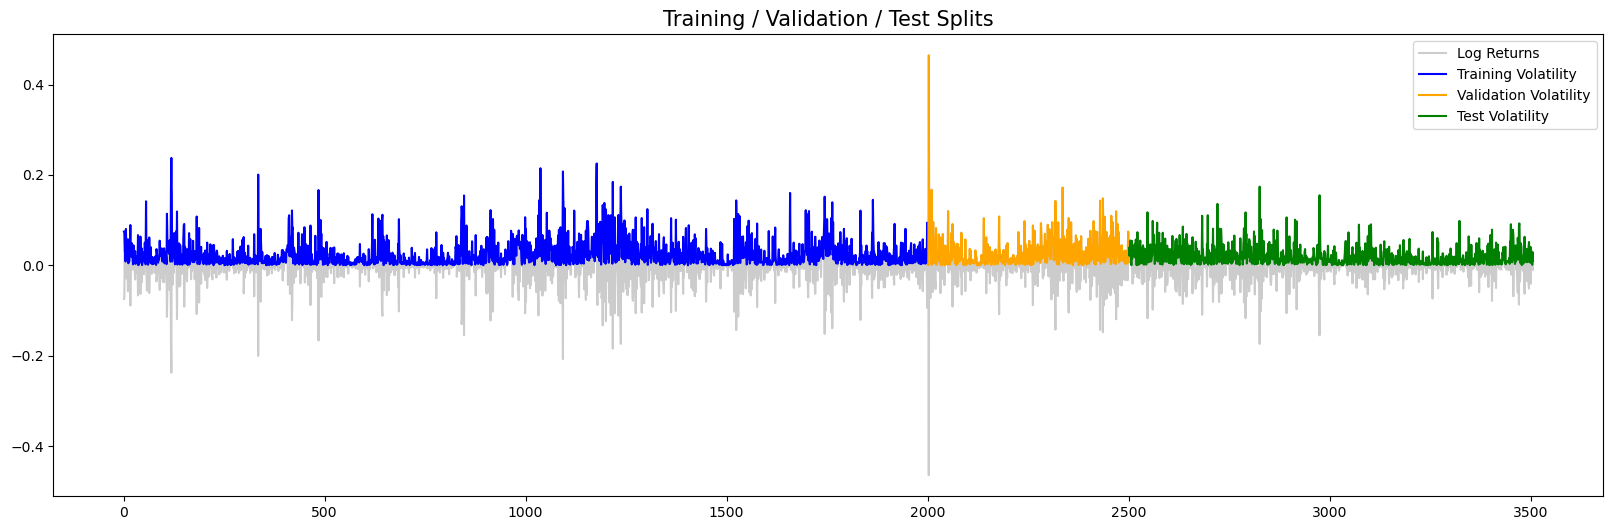

In [21]:
plt.figure(figsize=(20,6))

plt.plot(log_returns, color='gray', label='Log Returns', alpha=0.4)

plt.plot(vol_train, color='blue', label='Training Volatility')
plt.plot(vol_val, color='orange', label='Validation Volatility')
plt.plot(vol_test, color='green', label='Test Volatility')

plt.plot()
plt.title('Training / Validation / Test Splits', fontsize=15)
plt.legend()
plt.show();

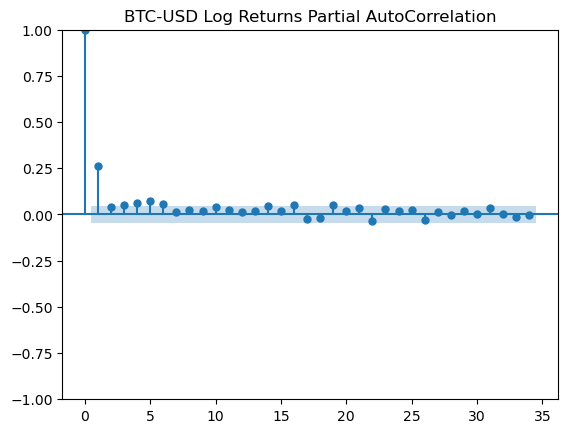

In [22]:
plot_pacf(ts_train**2,title=f'{tckr.upper()} Log Returns Partial AutoCorrelation');

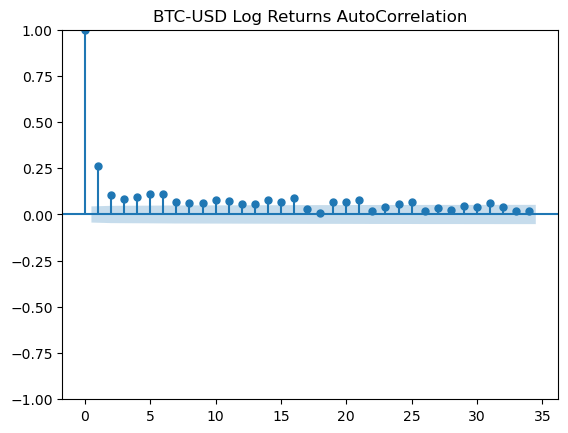

In [23]:
plot_acf(ts_train**2,
          title=f'{tckr.upper()} Log Returns AutoCorrelation');

In [24]:
# CALCULATE THE MEAN OF TRAINING DATA
mean_train_vol = vol_train.mean()
mean_train_vol

0.025001130673677638

In [25]:
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(ts_val)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=ts_val.index)

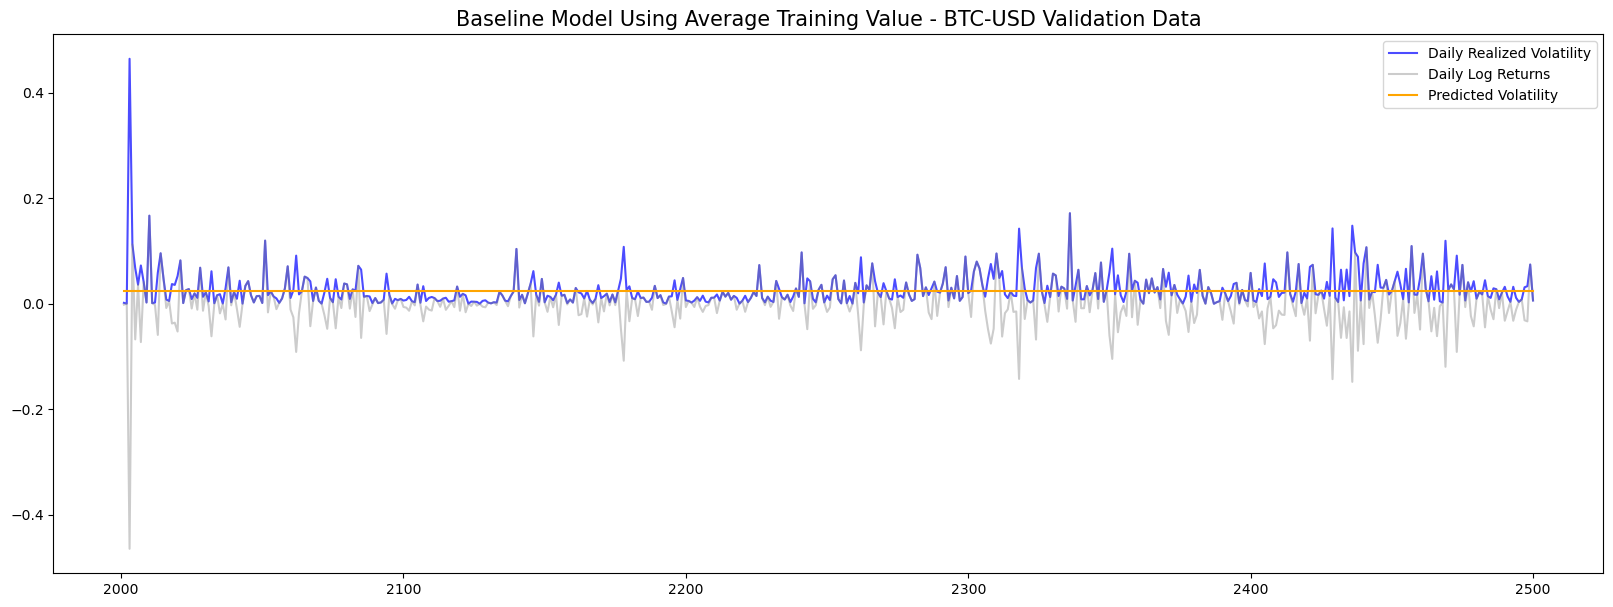

In [26]:
plt.figure(figsize=(20,7))
plt.plot(vol_val, color='blue', label='Daily Realized Volatility', alpha=0.7)
plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')
plt.plot(baseline_preds, color='orange', label='Predicted Volatility')

plt.title(f'Baseline Model Using Average Training Value - {tckr} Validation Data', fontsize=15)
plt.legend();

In [27]:
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [28]:
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [29]:
RMSE(vol_val, baseline_preds)

0.0344730298329825

In [30]:
RMSPE(vol_val, baseline_preds)

65.60196881235626

In [31]:
random_walk_preds = vols.shift(1).dropna()[val_idx]

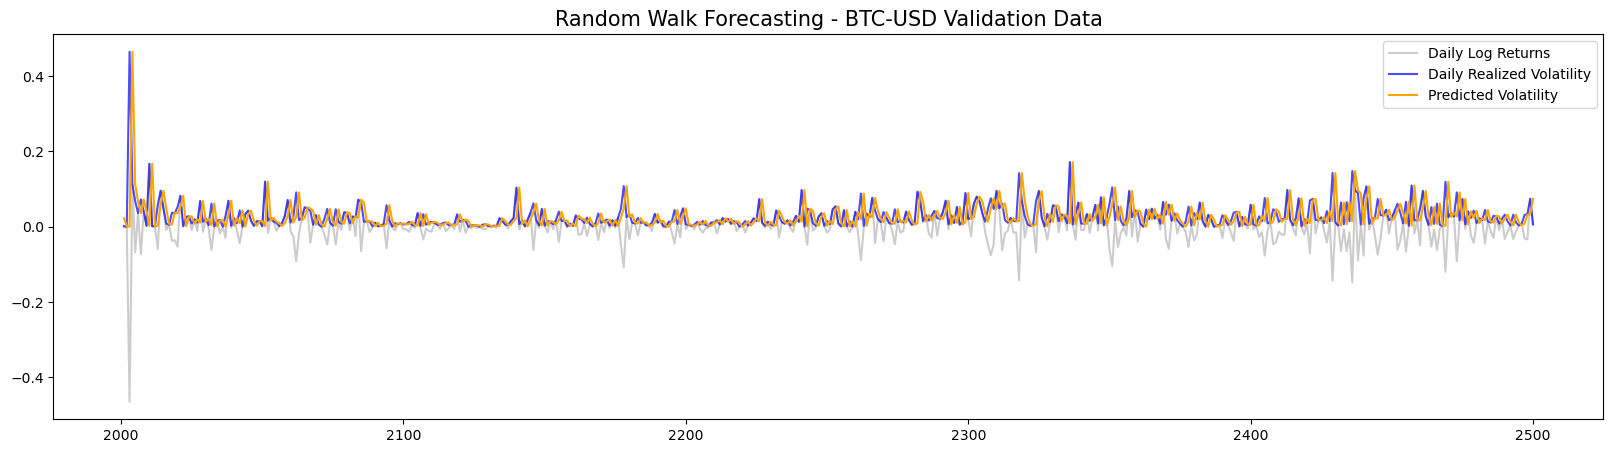

In [32]:
plt.figure(figsize=(20,5))
plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')
plt.plot(vol_val, color='blue', alpha=0.7,
         label='Daily Realized Volatility')
plt.plot(random_walk_preds, color='orange', label='Predicted Volatility')

plt.title(f'Random Walk Forecasting - {tckr} Validation Data', fontsize=15)
plt.legend();

In [33]:
RMSE(vol_val, random_walk_preds)

0.04665309806928882

In [34]:
RMSPE(vol_val, random_walk_preds)

48.95728383668088

In [35]:
from arch import arch_model

In [36]:
gm_1 = arch_model(ts_train, vol='GARCH', p=1, q=1,
                  mean='Zero', dist='normal')
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3898.52
Distribution:                  Normal   AIC:                          -7791.04
Method:            Maximum Likelihood   BIC:                          -7774.23
                                        No. Observations:                 2000
Date:                Thu, Apr 25 2024   Df Residuals:                     2000
Time:                        10:00:33   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0831e-04  4.786e-05      2.263  2.363e-02 [1

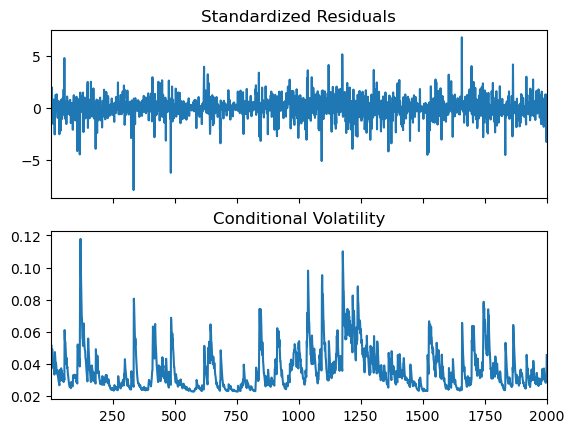

In [37]:
result_1.plot()
plt.show();

In [38]:
# ROLLING FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = log_returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       mean='Zero', dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [39]:
rolling_predictions_1 = pd.Series(rolling_forecasts, index=ts_val.index)

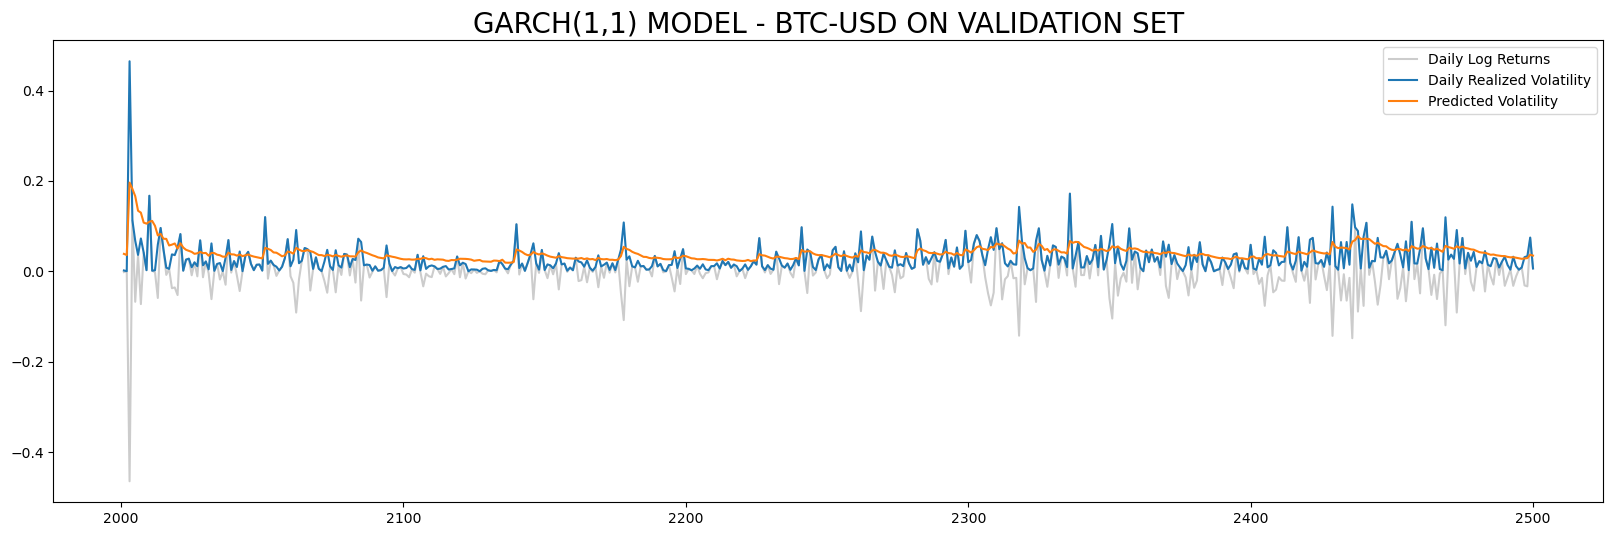

In [40]:
plt.figure(figsize=(20,6))
plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')

plt.plot(vol_val, label='Daily Realized Volatility')
plt.plot(rolling_predictions_1, label='Predicted Volatility')

plt.title(f'GARCH(1,1) MODEL - {tckr} ON VALIDATION SET', fontsize=20)
plt.legend();

In [41]:
RMSE(vol_val, rolling_predictions_1)

0.030734388440059997

In [42]:
RMSPE(vol_val, rolling_predictions_1)

80.77265611077499

In [43]:
gjr_gm = arch_model(ts_train, p=1, q=1, o=1,
                    mean='Zero', vol='GARCH')

In [44]:
result_2 = gjr_gm.fit(disp='off')
print()
print(result_2.summary())


                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                3889.02
Distribution:                  Normal   AIC:                          -7770.03
Method:            Maximum Likelihood   BIC:                          -7747.63
                                        No. Observations:                 2000
Date:                Thu, Apr 25 2024   Df Residuals:                     2000
Time:                        10:00:58   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.4674e-04  1.572e-04      0.933      0.351

In [45]:
# ROLLING FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = log_returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1,
                        mean='Zero', vol='GARCH')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [46]:
rolling_predictions_2 = pd.Series(rolling_forecasts, index=ts_val.index)

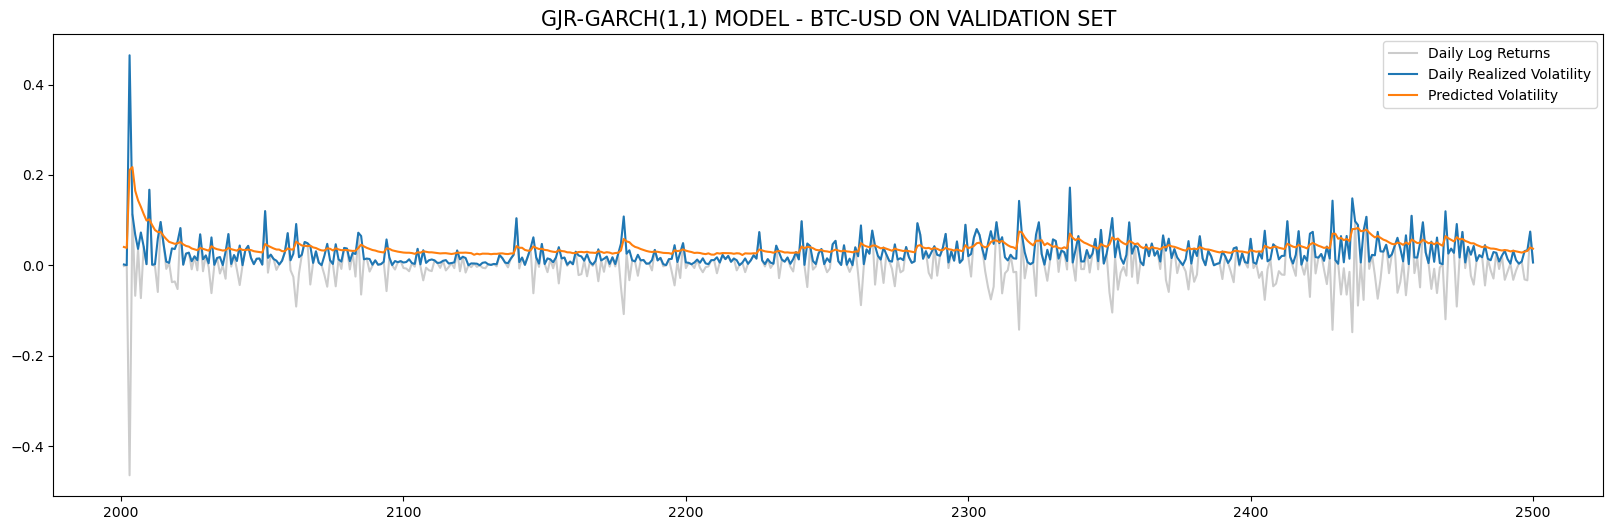

In [47]:
plt.figure(figsize=(20,6))
plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')

plt.plot(vol_val, label='Daily Realized Volatility')
plt.plot(rolling_predictions_2, label='Predicted Volatility')

plt.title(f'GJR-GARCH(1,1) MODEL - {tckr} ON VALIDATION SET', fontsize=15)
plt.legend();

In [48]:
RMSPE(vol_val, rolling_predictions_2)

80.12139811392387

In [49]:
RMSE(vol_val, rolling_predictions_2)

0.03001151720799619

In [50]:
e_gm = arch_model(ts_train, p=1, q=1, o=1,
                    mean='Zero', vol='EGARCH')
result_3 = e_gm.fit(disp='off')
print()
print(result_3.summary())


                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                3913.05
Distribution:                  Normal   AIC:                          -7818.10
Method:            Maximum Likelihood   BIC:                          -7795.69
                                        No. Observations:                 2000
Date:                Thu, Apr 25 2024   Df Residuals:                     2000
Time:                        10:01:16   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         -0.4853      0.144     -3.361  7.775e-04

In [51]:
# EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = log_returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1,
                        mean='Zero', vol='EGARCH')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [52]:
rolling_predictions_3 = pd.Series(rolling_forecasts, index=ts_val.index)

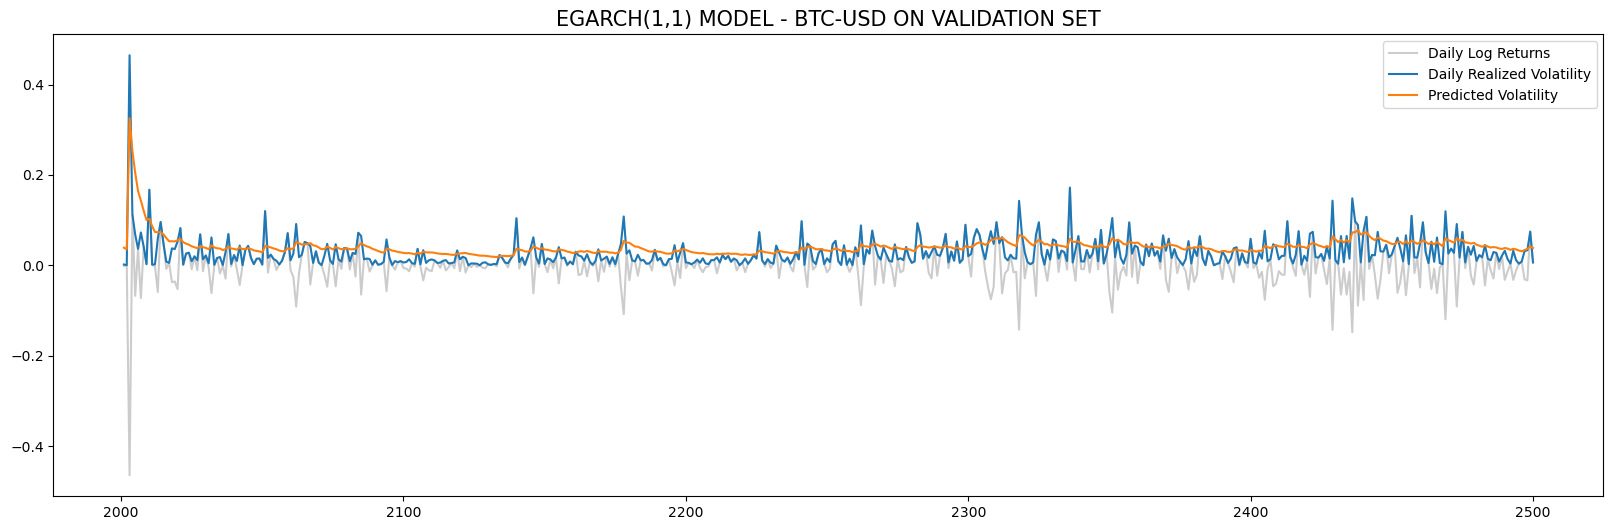

In [53]:
plt.figure(figsize=(20,6))
plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')

plt.plot(vol_val, label='Daily Realized Volatility')
plt.plot(rolling_predictions_3, label='Predicted Volatility')

plt.title(f'EGARCH(1,1) MODEL - {tckr} ON VALIDATION SET', fontsize=15)
plt.legend();

In [54]:
RMSPE(vol_val, rolling_predictions_3)

81.77383780712229

In [55]:
RMSE(vol_val, rolling_predictions_3)

0.029717514642188726

In [56]:
e_gm_t = arch_model(ts_train, p=1, q=1, o=1,
                    mean='Zero', vol='EGARCH', dist='StudentsT')
result_4 = e_gm_t.fit(disp='off')
print()
print(result_4.summary())


                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:                4193.61
Distribution:      Standardized Student's t   AIC:                          -8377.23
Method:                  Maximum Likelihood   BIC:                          -8349.22
                                              No. Observations:                 2000
Date:                      Thu, Apr 25 2024   Df Residuals:                     2000
Time:                              10:01:43   Df Model:                            0
                               Volatility Model                               
                  coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------------------------------------------------

In [57]:
# ROLLING FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = log_returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1,
                        mean='Zero', vol='EGARCH', dist='StudentsT')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [58]:
rolling_predictions_4 = pd.Series(rolling_forecasts, index=ts_val.index)

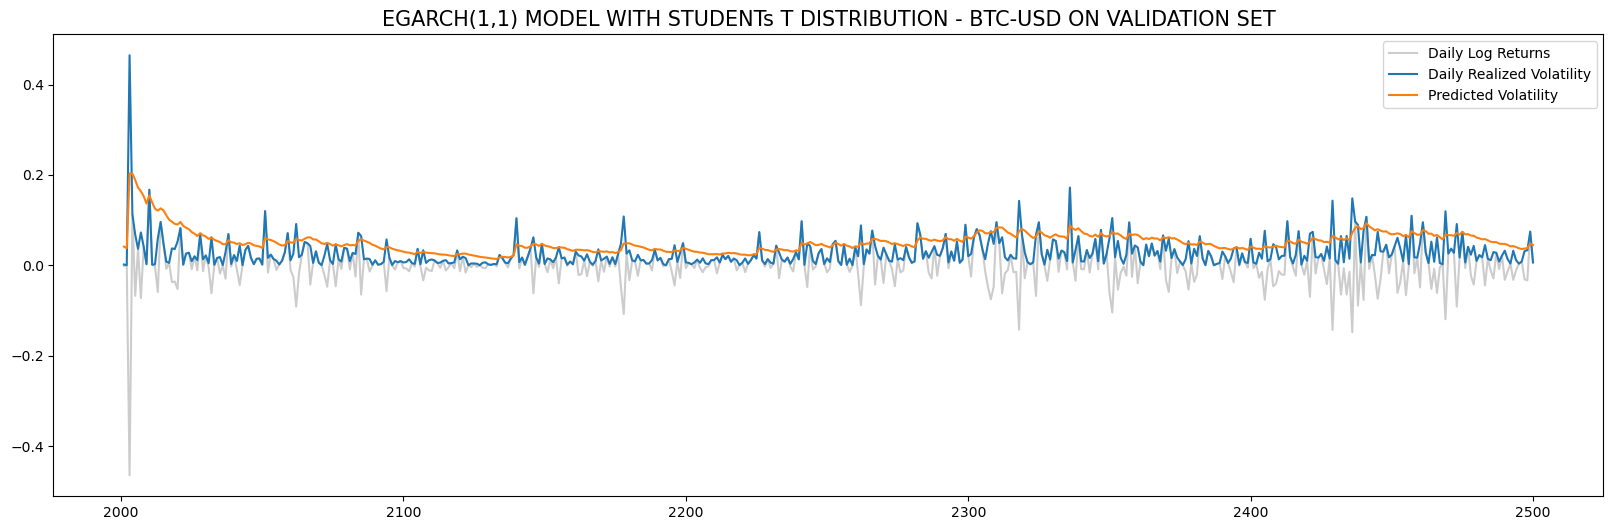

In [59]:
plt.figure(figsize=(20,6))
plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')

plt.plot(vol_val, label='Daily Realized Volatility')
plt.plot(rolling_predictions_4, label='Predicted Volatility')

plt.title(f'EGARCH(1,1) MODEL WITH STUDENTs T DISTRIBUTION - {tckr} ON VALIDATION SET', fontsize=15)
plt.legend();

In [60]:
RMSPE(vol_val, rolling_predictions_4)

104.18692628877179

In [61]:
import tensorflow as tf

In [62]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [63]:
window_size = 14
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(vol_train, window_size, batch_size, shuffle_buffer_size)

In [64]:
lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.LSTM(28, activation='relu'),
    tf.keras.layers.Dense(1)
])

lstm_1.compile(optimizer='adam', loss='mse')
lstm_1.fit(dataset, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
63/63 - 1s - 10ms/step - loss: 7.8948e-04
Epoch 2/100
63/63 - 0s - 2ms/step - loss: 7.6316e-04
Epoch 3/100


2024-04-25 10:02:26.551428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:26.687944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.5582e-04
Epoch 4/100
63/63 - 0s - 2ms/step - loss: 7.4443e-04
Epoch 5/100


2024-04-25 10:02:26.822322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:26.955180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.4331e-04
Epoch 6/100
63/63 - 0s - 3ms/step - loss: 7.4640e-04
Epoch 7/100


2024-04-25 10:02:27.085133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:27.264055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3785e-04
Epoch 8/100
63/63 - 0s - 2ms/step - loss: 7.3652e-04
Epoch 9/100


2024-04-25 10:02:27.400482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:27.533699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.4313e-04
Epoch 10/100
63/63 - 0s - 2ms/step - loss: 7.3682e-04
Epoch 11/100


2024-04-25 10:02:27.665439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:27.797105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.4140e-04
Epoch 12/100
63/63 - 0s - 2ms/step - loss: 7.3518e-04
Epoch 13/100


2024-04-25 10:02:27.927732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:28.058010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3576e-04
Epoch 14/100
63/63 - 0s - 2ms/step - loss: 7.3972e-04
Epoch 15/100


2024-04-25 10:02:28.187896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:28.324709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.4349e-04
Epoch 16/100
63/63 - 0s - 2ms/step - loss: 7.4094e-04
Epoch 17/100


2024-04-25 10:02:28.453746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:28.582424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.5347e-04
Epoch 18/100
63/63 - 0s - 2ms/step - loss: 7.3611e-04
Epoch 19/100


2024-04-25 10:02:28.712331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:28.841997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3831e-04
Epoch 20/100
63/63 - 0s - 2ms/step - loss: 7.4275e-04
Epoch 21/100


2024-04-25 10:02:28.971395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:29.101022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3712e-04
Epoch 22/100
63/63 - 0s - 2ms/step - loss: 7.3386e-04
Epoch 23/100


2024-04-25 10:02:29.231790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:29.364244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3666e-04
Epoch 24/100
63/63 - 0s - 2ms/step - loss: 7.3977e-04
Epoch 25/100


2024-04-25 10:02:29.498505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:29.631347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.4001e-04
Epoch 26/100
63/63 - 0s - 2ms/step - loss: 7.3897e-04
Epoch 27/100


2024-04-25 10:02:29.763779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:29.896117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3608e-04
Epoch 28/100
63/63 - 0s - 2ms/step - loss: 7.3278e-04
Epoch 29/100


2024-04-25 10:02:30.028434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:30.162005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3853e-04
Epoch 30/100
63/63 - 0s - 2ms/step - loss: 7.4334e-04
Epoch 31/100


2024-04-25 10:02:30.292458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:30.424905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3790e-04
Epoch 32/100
63/63 - 0s - 2ms/step - loss: 7.3513e-04
Epoch 33/100


2024-04-25 10:02:30.556197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:30.689735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3813e-04
Epoch 34/100
63/63 - 0s - 2ms/step - loss: 7.3765e-04
Epoch 35/100


2024-04-25 10:02:30.821510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:30.954189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3936e-04
Epoch 36/100
63/63 - 0s - 2ms/step - loss: 7.4399e-04
Epoch 37/100


2024-04-25 10:02:31.085883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:31.219082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3696e-04
Epoch 38/100
63/63 - 0s - 2ms/step - loss: 7.3447e-04
Epoch 39/100


2024-04-25 10:02:31.350357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:31.481835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3874e-04
Epoch 40/100
63/63 - 0s - 2ms/step - loss: 7.4395e-04
Epoch 41/100


2024-04-25 10:02:31.613099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:31.743490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.4785e-04
Epoch 42/100
63/63 - 0s - 2ms/step - loss: 7.4740e-04
Epoch 43/100


2024-04-25 10:02:31.872808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:32.002469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3918e-04
Epoch 44/100
63/63 - 0s - 2ms/step - loss: 7.4010e-04
Epoch 45/100


2024-04-25 10:02:32.132597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:32.263517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3880e-04
Epoch 46/100
63/63 - 0s - 2ms/step - loss: 7.3240e-04
Epoch 47/100


2024-04-25 10:02:32.396178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:32.527775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3820e-04
Epoch 48/100
63/63 - 0s - 2ms/step - loss: 7.3277e-04
Epoch 49/100


2024-04-25 10:02:32.678176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:32.829246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.4098e-04
Epoch 50/100
63/63 - 0s - 2ms/step - loss: 7.3559e-04
Epoch 51/100


2024-04-25 10:02:32.959994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:33.091750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3976e-04
Epoch 52/100
63/63 - 0s - 2ms/step - loss: 7.3721e-04
Epoch 53/100


2024-04-25 10:02:33.223485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:33.353742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3164e-04
Epoch 54/100
63/63 - 0s - 2ms/step - loss: 7.3968e-04
Epoch 55/100


2024-04-25 10:02:33.486789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:33.620606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3947e-04
Epoch 56/100
63/63 - 0s - 2ms/step - loss: 7.3861e-04
Epoch 57/100


2024-04-25 10:02:33.754152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:33.887466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.4111e-04
Epoch 58/100
63/63 - 0s - 2ms/step - loss: 7.3176e-04
Epoch 59/100


2024-04-25 10:02:34.024702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:34.157841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2896e-04
Epoch 60/100
63/63 - 0s - 2ms/step - loss: 7.3598e-04
Epoch 61/100


2024-04-25 10:02:34.290340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:34.420853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3216e-04
Epoch 62/100
63/63 - 0s - 2ms/step - loss: 7.5934e-04
Epoch 63/100


2024-04-25 10:02:34.550636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:34.679338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3615e-04
Epoch 64/100
63/63 - 0s - 2ms/step - loss: 7.3405e-04
Epoch 65/100


2024-04-25 10:02:34.808583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:34.938123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3305e-04
Epoch 66/100
63/63 - 0s - 2ms/step - loss: 7.4018e-04
Epoch 67/100


2024-04-25 10:02:35.069005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:35.198440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3899e-04
Epoch 68/100
63/63 - 0s - 2ms/step - loss: 7.3386e-04
Epoch 69/100


2024-04-25 10:02:35.328408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:35.458042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2599e-04
Epoch 70/100
63/63 - 0s - 2ms/step - loss: 7.3118e-04
Epoch 71/100


2024-04-25 10:02:35.587956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:35.718503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2994e-04
Epoch 72/100
63/63 - 0s - 2ms/step - loss: 7.3066e-04
Epoch 73/100


2024-04-25 10:02:35.848239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:35.978399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3030e-04
Epoch 74/100
63/63 - 0s - 2ms/step - loss: 7.3175e-04
Epoch 75/100


2024-04-25 10:02:36.107486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:36.236707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3517e-04
Epoch 76/100
63/63 - 0s - 2ms/step - loss: 7.3460e-04
Epoch 77/100


2024-04-25 10:02:36.365554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:36.494367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3206e-04
Epoch 78/100
63/63 - 0s - 2ms/step - loss: 7.4174e-04
Epoch 79/100


2024-04-25 10:02:36.623902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:36.753332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3001e-04
Epoch 80/100
63/63 - 0s - 2ms/step - loss: 7.2867e-04
Epoch 81/100


2024-04-25 10:02:36.882880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:37.012149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2687e-04
Epoch 82/100
63/63 - 0s - 2ms/step - loss: 7.3042e-04
Epoch 83/100


2024-04-25 10:02:37.141469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:37.270656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2747e-04
Epoch 84/100
63/63 - 0s - 2ms/step - loss: 7.4528e-04
Epoch 85/100


2024-04-25 10:02:37.400300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:37.531097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3149e-04
Epoch 86/100
63/63 - 0s - 3ms/step - loss: 7.3014e-04
Epoch 87/100


2024-04-25 10:02:37.660011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:37.826525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2632e-04
Epoch 88/100
63/63 - 0s - 2ms/step - loss: 7.2842e-04
Epoch 89/100


2024-04-25 10:02:37.964021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:38.093238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2670e-04
Epoch 90/100
63/63 - 0s - 2ms/step - loss: 7.2479e-04
Epoch 91/100


2024-04-25 10:02:38.221785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:38.350688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2749e-04
Epoch 92/100
63/63 - 0s - 2ms/step - loss: 7.3737e-04
Epoch 93/100


2024-04-25 10:02:38.480322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:38.608222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3311e-04
Epoch 94/100
63/63 - 0s - 2ms/step - loss: 7.3506e-04
Epoch 95/100


2024-04-25 10:02:38.738132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:38.867030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2820e-04
Epoch 96/100
63/63 - 0s - 2ms/step - loss: 7.3223e-04
Epoch 97/100


2024-04-25 10:02:38.996743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:39.125578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2812e-04
Epoch 98/100
63/63 - 0s - 2ms/step - loss: 7.3804e-04
Epoch 99/100


2024-04-25 10:02:39.255665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:39.383960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3820e-04
Epoch 100/100
63/63 - 0s - 2ms/step - loss: 7.2380e-04


2024-04-25 10:02:39.514071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 10:02:39.642892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [65]:

forecast = []
idx = vols.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(vol_val)):
    # GET THE DATA AT THE PREVIOUS window_size TIME STEPS
    from_idx = idx[split_time_1 + i - window_size]
    to_idx = idx[split_time_1 + i - 1]
    pred = lstm_1.predict(vols[from_idx:to_idx].values[np.newaxis])
    forecast.append(pred)

forecast = np.array(forecast[-len(vol_val):])[:, 0, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [66]:
rolling_predictions_5 = pd.Series(forecast, index=ts_val.index)

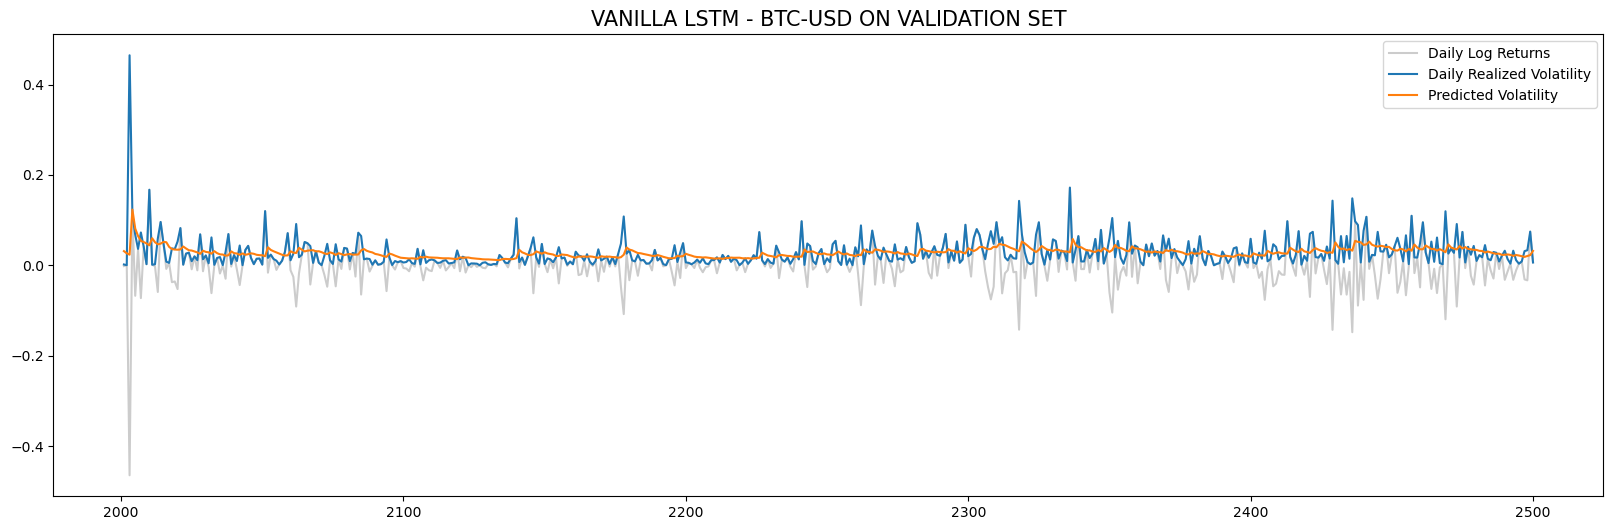

In [68]:
plt.figure(figsize=(20,6))
plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')

plt.plot(vol_val, label='Daily Realized Volatility')
plt.plot(rolling_predictions_5, label='Predicted Volatility')

plt.title(f'VANILLA LSTM - {tckr} ON VALIDATION SET', fontsize=15)
plt.legend();

In [69]:
RMSPE(vol_val, rolling_predictions_5)

59.57101805373266

In [70]:
RMSE(vol_val, rolling_predictions_5)

0.03383412834066305